In [108]:
import sparse
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import scipy as sp
import sys
import io
from tqdm import tqdm, trange

import dice_ml
from dice_ml.utils import helpers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('..')
from learn_distance.evaluate import *
from learn_distance.ordinal import *

In [3]:
problem = 'ARF_4h'
dataset = 'mimic3'

s = sparse.load_npz('../data/fiddle/FIDDLE_{dataset}/features/{problem}/s.npz'.format(problem=problem, dataset=dataset)).todense()
x = sparse.load_npz('../data/fiddle/FIDDLE_{dataset}/features/{problem}/X.npz'.format(problem=problem, dataset=dataset)).todense()

s_feats = json.load(open('../data/fiddle/FIDDLE_{dataset}/features/{problem}/s.feature_names.json'.format(problem=problem, dataset=dataset), 'r'))
x_feats = json.load(open('../data/fiddle/FIDDLE_{dataset}/features/{problem}/X.feature_names.json'.format(problem=problem, dataset=dataset), 'r'))

y = pd.read_csv('../data/fiddle/FIDDLE_{dataset}/population/{problem}.csv'.format(problem=problem, dataset=dataset))

In [4]:
end = x.shape[1]-1
d = x[:,end,:] - x[:,0,:]
x_start = np.hstack([s,x[:,0,:]])
x_end = np.hstack([s,x[:,end,:]])
feats = s_feats + x_feats

In [5]:
frequent = ['DiaBP', 'HR', 'SpO2', 'RR', 'SysBP']
stats = ['value', 'max', 'min', 'mean']
feat_idx, sets, freq_stats = get_feature_idx(
    frequent=frequent,
    stats=stats,
    x_feats=x_feats,
    s_feats=s_feats)

In [6]:
df_start = pd.DataFrame(ohe_to_ordinal(
    feature_sets=sets,
    feat_idx=feat_idx,
    x=x_start
))

df_end = pd.DataFrame(ohe_to_ordinal(
    feature_sets=sets,
    feat_idx=feat_idx,
    x=x_end
))

na_start = get_na_mask(x_start, freq_stats, feat_idx)
na_end = get_na_mask(x_end, freq_stats, feat_idx)

In [7]:
na_both = np.logical_and(na_start, na_end)

df_start = df_start.iloc[na_both,:]
df_end = df_end.iloc[na_both,:]

y_start = y['ARF_LABEL'][na_start]
y_end = y['ARF_LABEL'][na_end]
y_both = y['ARF_LABEL'][na_both]

In [8]:
xtr, xte, ytr, yte = train_test_split(df_start, y_both, stratify=y_both, random_state=123)
boundary = LogisticRegression(solver='liblinear', penalty='l1')
boundary.fit(xtr, ytr)

LogisticRegression(penalty='l1', solver='liblinear')

In [88]:
train = pd.DataFrame(xtr, columns = df_start.columns)
train['label'] = ytr

start = train.drop(columns=['label'])

test = pd.DataFrame(xte, columns=df_start.columns)
test['label'] = yte

In [10]:
coef_df = pd.DataFrame(
    {'feat' : df_start.columns,
    'coef' : boundary.coef_.flatten(),
    'abs_coef' : np.abs(boundary.coef_.flatten())})

coef_df.sort_values(by=['abs_coef'], ascending=False)[:20]

,feat,coef,abs_coef
763,225892_value,2.027556,2.027556
72,221794_value,-1.645414,1.645414
1299,70059_value,1.473608,1.473608
840,226363_value,1.343088,1.343088
851,226375_value,-1.335236,1.335236
1307,70088_value,1.207498,1.207498
496,224974_value,1.207266,1.207266
346,224369_value,-1.200431,1.200431
654,225439_value,1.135540,1.135540
17,220862_Rate,1.106664,1.106664


In [11]:
hundred = train.iloc[:100,:]
m = dice_ml.Model(model=boundary, backend="sklearn")
d = dice_ml.Data(dataframe=train, continuous_features=freq_stats, outcome_name='label')
exp = dice_ml.Dice(d, m, method="random")

In [138]:
pos = np.where(yte==1)
diff = df_end - df_start

In [39]:
def compare_cf(d, diff, mad, ftv, tol=1e-5, n_avg=5):
   d = d[ftv]
   comp = diff[ftv]
   distance = []
   for i in range(comp.shape[0]):
      distance.append(np.sum(np.abs(d - comp.iloc[i,:])/(mad+tol)))
   distance = np.sort(distance)
   return np.sum(distance[:n_avg])/n_avg

In [167]:
def evaluate_rank(df, model, diff, ftv, cont=[], n_cfs=3, n_avg=5):
    m = dice_ml.Model(model=model, backend="sklearn")
    d = dice_ml.Data(dataframe=df, continuous_features=cont, outcome_name='label')
    exp = dice_ml.Dice(d, m, method="random")
    all_comparisons = []
    top_comparisons = []
    top_cfs = []
    bot_cfs = []
    failed = []
    few = []
    few_cfs = []
    changes = pd.DataFrame(columns = ['idx', 'cf_idx'] + ftv)
    mad = sp.stats.median_abs_deviation(diff[ftv])
    for i in trange(df.shape[0]):
        query = df.iloc[i:(i+1),:]
        query = query.drop(columns=['label'])
        e = exp.generate_counterfactuals(
            query,
            total_CFs=n_cfs, 
            desired_class="opposite",
            features_to_vary=ftv)
        cfs = e.cf_examples_list[0].final_cfs_df
        if cfs is None:
            failed.append(i)
            continue
        elif cfs.shape[0] < n_cfs:
            few.append(i)
            few_cfs.append(cfs)
            continue
        comparisons = []
        for j in trange(n_cfs):
            d = cfs.iloc[j,:-1].apply(pd.to_numeric) - query.iloc[0,:].apply(pd.to_numeric)
            c = compare_cf(
                d=d,
                diff=diff,
                mad=mad,
                ftv=ftv
            )
            row = []
            changes.loc[len(changes)] = [int(i), int(j)] + list(np.zeros(len(ftv)))
            changes.iloc[i,:][ftv] = d
            all_comparisons.append(c)
            comparisons.append(c)
        top = np.argmin(comparisons)
        bot = np.argmax(comparisons)
        top_comparisons.append(comparisons[top])

        top_cfs.append(cfs.iloc[top,:])
        bot_cfs.append(cfs.iloc[bot,:])
    results = {
        'all' : all_comparisons,
        'top' : top_comparisons,
        'top_cfs' : top_cfs,
        'bot_cfs' : bot_cfs,
        'failed' : failed,
        'few' : few,
        'few_cfs' : few_cfs,
        'changes' : changes
    }
    return results

In [48]:
test_pos = test.iloc[pos]
test_pos[freq_stats] = test_pos[freq_stats].apply(pd.to_numeric)

/Users/alex/miniconda3/envs/cfe/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [168]:
eval_df = test_pos.iloc[:20,:]
results = evaluate_rank(
    df = eval_df,
    model = boundary,
    diff = diff,
    n_cfs=10,
    n_avg=3,
    ftv = freq_stats,
    cont = freq_stats
)

/Users/alex/miniconda3/envs/cfe/lib/python3.7/site-packages/dice_ml/data_interfaces/public_data_interface.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_df[feature] = self.data_df[feature].apply(str)
/Users/alex/miniconda3/envs/cfe/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/alex/miniconda3/envs/cfe/lib/python3.7/site-packages/dice_ml/data_interfaces/public_data_interface.py:71: SettingWithCopyWarning: 
A va

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 15%|█▌        | 3/20 [00:46<03:19, 11.73s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 30%|███       | 6/20 [02:07<04:37, 19.85s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 45%|████▌     | 9/20 [03:30<04:04, 22.27s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 55%|█████▌    | 11/20 [04:12<03:01, 20.15s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 60%|██████    | 12/20 [04:16<02:01, 15.22s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 75%|███████▌  | 15/20 [05:37<01:40, 20.17s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


 80%|████████  | 16/20 [05:42<01:02, 15.69s/it]

Only 9 (required 10) Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 85%|████████▌ | 17/20 [05:47<00:37, 12.43s/it]

Only 3 (required 10) Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 04 sec


 95%|█████████▌| 19/20 [06:32<00:15, 15.79s/it]

No Counterfactuals found for the given configuation, perhaps try with different parameters... ; total time taken: 00 min 03 sec


100%|██████████| 20/20 [07:10<00:00, 21.52s/it]


In [96]:
print(np.average(results['all']))
np.average(results['top'])

78742.43257567425


9103.927142546756

In [208]:
moving = np.where(-np.all(results['changes'][['idx', 'cf_idx'] +freq_stats]==0, axis=0))
changing_vars = results['changes'][results['changes'].columns[moving]].drop(columns=['idx', 'cf_idx'])
changing_vars

,DiaBP_value,DiaBP_min,DiaBP_mean,HR_max,HR_min,SpO2_value,SpO2_max,SpO2_min,SpO2_mean,RR_value,RR_max,RR_min,SysBP_value,SysBP_max,SysBP_mean
0,0.0,0.0,0.0,0.0,0.0,-2.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
unique_vals = {}
for i in range(changing_vars.shape[1]):
    unq = np.unique(changing_vars.iloc[:,i])
    unique_vals[changing_vars.columns[i]] = unq
unique_vals

{'DiaBP_value': array([0., 1.]),
 'DiaBP_min': array([-1.,  0.,  2.]),
 'DiaBP_mean': array([-3., -2.,  0.,  3.]),
 'HR_max': array([-3.,  0.]),
 'HR_min': array([0., 3.]),
 'SpO2_value': array([-2.,  0.]),
 'SpO2_max': array([-3., -1.,  0.]),
 'SpO2_min': array([0., 4.]),
 'SpO2_mean': array([0., 4.]),
 'RR_value': array([-3.,  0.,  2.]),
 'RR_max': array([0., 1., 3.]),
 'RR_min': array([-4.,  0.,  2.]),
 'SysBP_value': array([-3., -2.,  0.,  1.]),
 'SysBP_max': array([-1.,  0.,  2.]),
 'SysBP_mean': array([0., 1.])}

<AxesSubplot:>

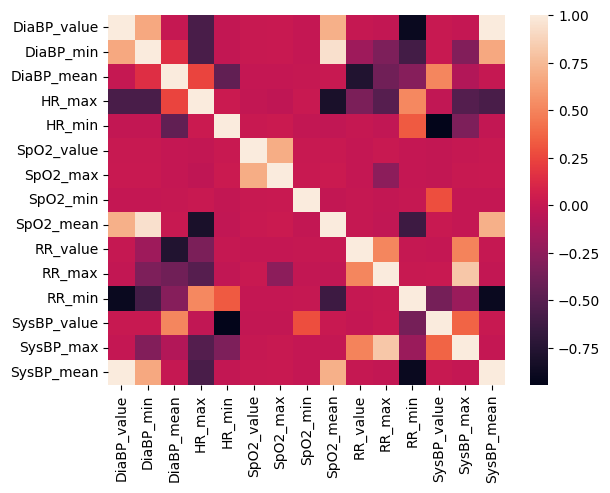

In [210]:
sns.heatmap(changing_vars.corr())

In [97]:
results['top']

[1.9999800001999979,
 2.9999700002999967,
 2.599974000259997,
 20026.59973400266,
 8.999910000899991,
 21.999780002199977,
 3.5999640003599964,
 20021.199788002115,
 60023.59976400235,
 27.599724002759967,
 1.9999800001999979]

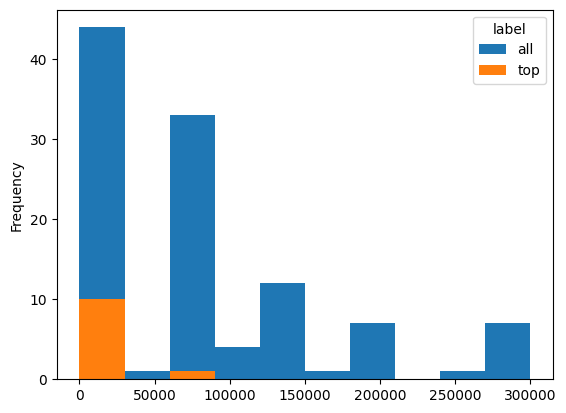

In [98]:
top_list = list(np.repeat('top', len(results['top'])))
all_list = list(np.repeat('all', len(results['all'])))
res_df = pd.DataFrame(
    {
        'label' : all_list + top_list,
        'distance' : results['all'] + results['top']  
    }
)
res_df.pivot(columns='label', values='distance').plot.hist()
plt.show()

In [133]:
y_tt = np.concatenate([ytr, yte])
pos_tt = np.where(y_tt == 1)[0]
diff_pos = diff.iloc[pos_tt]
change_cov = np.cov(diff_pos.T)
evals, evecs = np.linalg.eigh(change_cov)

In [225]:
evecs[:,-1]

array([ 0.01820459,  0.02202093,  0.00390191, ..., -0.00376135,
       -0.00238653,  0.01865682])

In [227]:
top_eig = np.where(np.abs(evecs[:,-1]) > np.quantile(np.abs(evecs[:,-1]), [0.98]))

In [229]:
diff.columns[top_eig]

Index(['223791_value', '223795_value', '223898_value', '223900_value',
       '223901_value', '223902_value', '223911_value', '223917_value',
       '223918_value', '223919_value', '223920_value', '223935_value',
       '223947_value', '223985_value', '223986_value', '223987_value',
       '223989_value', '223990_value', '224004_value', '224015_value',
       '224016_value', '224027_value', '224028_value', '224055_value',
       '224057_value', '224093_value', '224860_value'],
      dtype='object')

In [223]:
np.sum(np.square(evecs[:,0]))

0.9999999999999988

In [215]:
print(np.sum(evals))
evals[-10:]

650.8436338446704


array([ 13.28369838,  13.8250068 ,  15.55968421,  16.76592678,
        21.84595882,  23.78318955,  27.60716714,  29.3359182 ,
        31.73400066, 150.02882599])

In [216]:
y_tt = np.concatenate([ytr, yte])
pos_tt = np.where(y_tt == 1)[0]
diff_pos_freq = diff.iloc[pos_tt][freq_stats]
evals_f, evecs_f = np.linalg.eigh(np.cov(diff_pos_freq.T))

In [217]:
print(np.sum(evals_f))
evals_f[-10:]

32.52924296548104


array([0.34397759, 0.4700932 , 0.56584295, 0.66755084, 1.12676959,
       2.53333347, 2.99917451, 5.81977283, 7.5696769 , 8.72347922])

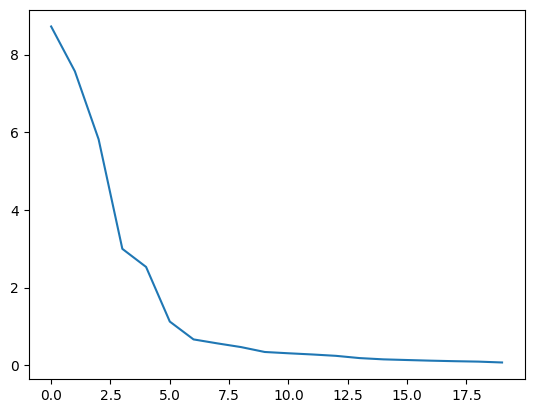

In [236]:
plt.plot(np.flip(evals_f))

In [238]:
evecs_f[:,-3]

array([ 0.19716742,  0.19981701,  0.18883417,  0.19995207, -0.05631526,
       -0.05696507, -0.05551583, -0.05798411, -0.13353981, -0.11466112,
       -0.10820223, -0.13848973, -0.41317689, -0.40362195, -0.36090884,
       -0.42251913,  0.17795755,  0.17342508,  0.18361855,  0.18156783])

In [237]:
freq_stats

['DiaBP_value',
 'DiaBP_max',
 'DiaBP_min',
 'DiaBP_mean',
 'HR_value',
 'HR_max',
 'HR_min',
 'HR_mean',
 'SpO2_value',
 'SpO2_max',
 'SpO2_min',
 'SpO2_mean',
 'RR_value',
 'RR_max',
 'RR_min',
 'RR_mean',
 'SysBP_value',
 'SysBP_max',
 'SysBP_min',
 'SysBP_mean']

In [232]:
top_eig = np.where(np.abs(evecs_f[:,-1]) > np.quantile(np.abs(evecs_f[:,-1]), [0.50]))
np.array(freq_stats)[top_eig]

array(['SysBP_mean'], dtype='<U11')

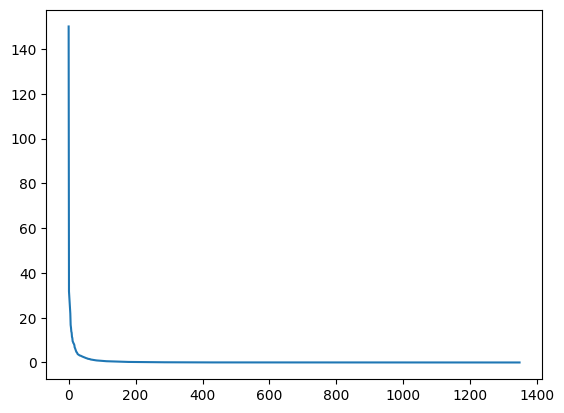

In [134]:
plt.plot(np.flip(evals))

<AxesSubplot:>

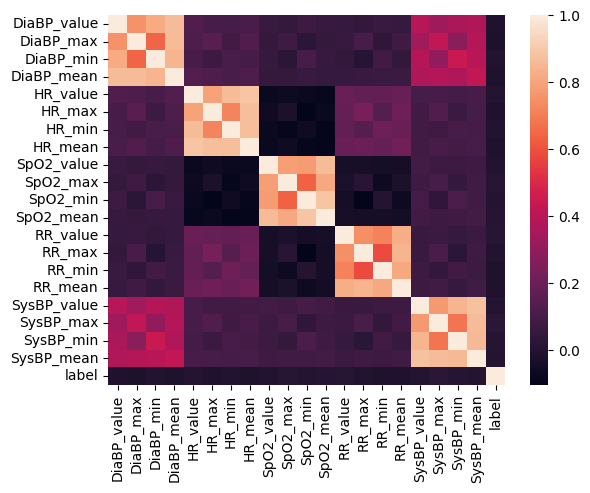

In [142]:
placeholder = diff.copy()
placeholder['label'] = y_tt
sns.heatmap(placeholder[freq_stats+['label']].corr())

<AxesSubplot:xlabel='label', ylabel='DiaBP_value'>

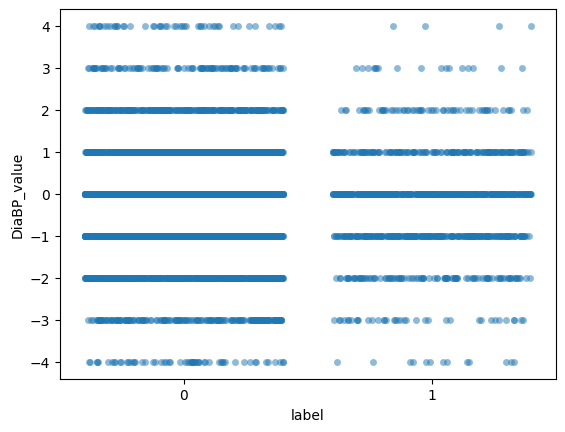

In [152]:
sns.stripplot(data=placeholder, y='DiaBP_value', x='label', jitter=0.4, alpha=0.5)